# Final charts


In [1]:
import numpy as np
import torch
from typing import Literal
import os
import json
from safetensors import safe_open
from safetensors.torch import load_file
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import wandb
import warnings
sys.path.append("../")
from jacobian_saes.utils import load_pretrained, run_sandwich


In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


## Jacobian sparsity
Run `runners/histogram.py` first to get the data

We also plot the cumulative density function because it lets us see the differences more easily

In [4]:
def get_hist_path(trained_with_jac: bool = True):
    return f"../results/histograms/sae_pair_pythia-410m-deduped_layer15_65536_J0{'.5' if trained_with_jac else ''}_k32:v0.safetensor"

with safe_open(get_hist_path(True), framework="pt") as f:
    hist = f.get_tensor("hist")
    bin_edges = f.get_tensor("bin_edges")
    n_tokens_in_hist = int(float(f.metadata()["tokens"]))

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
hist_no_optim = load_file(get_hist_path(False))["hist"]


In [9]:
upper_zoom_thresh = 0.1
cropped_bin_centers = bin_centers[bin_centers < upper_zoom_thresh]
cropped_hist = hist[bin_centers < upper_zoom_thresh]
cropped_hist_no_optim = hist_no_optim[bin_centers < upper_zoom_thresh]

cdf = cropped_hist.cumsum(dim=0) / hist.sum()
cdf_no_optim = cropped_hist_no_optim.cumsum(dim=0) / hist_no_optim.sum()


In [6]:
thresholds = [0.005, 0.01, 0.015, 0.02]
num_above_thresholds = []
num_above_thresholds_no_optim = []
for thresh in thresholds:
    # find the index of the bin edge that is equal to the threshold (assume it will always be there)
    idx = torch.where((bin_edges - thresh).abs() < 1e-6)[0].item()
    num_above_thresholds.append(hist[idx:].sum().item() / n_tokens_in_hist)
    num_above_thresholds_no_optim.append(hist_no_optim[idx:].sum().item() / n_tokens_in_hist)
num_above_thresholds, num_above_thresholds_no_optim

([169.000768, 63.4083456, 32.4139712, 19.9012704],
 [789.5814656, 596.9984, 450.2798848, 342.0676096])

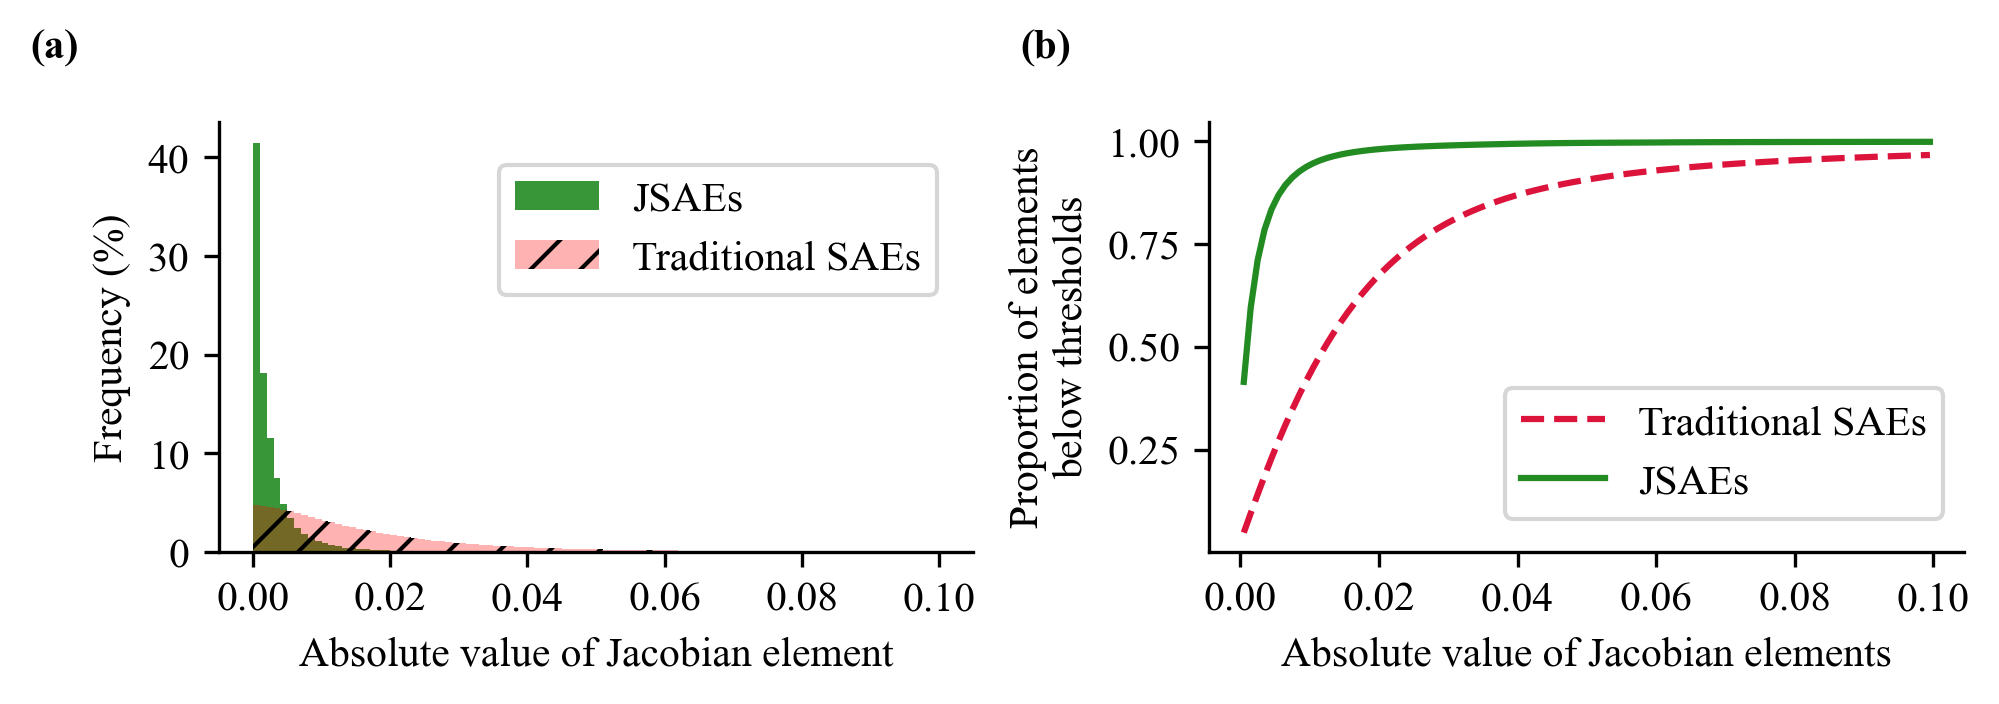

In [16]:
# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.75, 2.5), dpi=300)

# First subplot (histogram)
width = (bin_edges[1] - bin_edges[0]).item()
ax1.bar(cropped_bin_centers.cpu().numpy(), 
       cropped_hist.cpu().numpy() / hist.sum().item() * 100,
       width=width,
       color='forestgreen',
       alpha=0.9,
       label='JSAEs')
ax1.bar(cropped_bin_centers.cpu().numpy(),
       cropped_hist_no_optim.cpu().numpy() / hist_no_optim.sum().item() * 100,
       width=width,
       color='red',
       alpha=0.3,
       hatch='//',
       label='Traditional SAEs')
ax1.set_xlabel('Absolute value of Jacobian element')
ax1.set_ylabel('Frequency (%)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', bbox_to_anchor=(0.98, 0.95), fancybox=True)

# Second subplot (CDF)
ax2.plot(cropped_bin_centers.cpu().numpy(), 
       cdf_no_optim.cpu().numpy(),
       color='crimson',
       linestyle='--',
       label='Traditional SAEs')
ax2.plot(cropped_bin_centers.cpu().numpy(),
       cdf.cpu().numpy(),
       color='forestgreen',
       linestyle='-',
       label='JSAEs')
ax2.set_xlabel('Absolute value of Jacobian elements')
ax2.set_ylabel('Proportion of elements\nbelow thresholds')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.43), fancybox=True)

# Add subplot labels (a) and (b)
ax1.text(-0.25, 1.15, '(a)', transform=ax1.transAxes, fontsize=10, fontweight='bold')
ax2.text(-0.25, 1.15, '(b)', transform=ax2.transAxes, fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout(pad=1.0)

# Save the combined figure
plt.savefig('./charts/jac_hist_410m.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

One figure for demonstrating sparsity with a bunch of different metrics (subcharts) incl this one

The Jacobian is generally smaller here

# Example Jacobian before and after

In [8]:
def get_wandb_path(trained_with_jac: bool = True):
    return f"lucyfarnik/pythia-410m-v2/sae_pair_pythia-410m-deduped_layer15_65536_J0{'.5' if trained_with_jac else ''}_k32:v0"

sae_pair, model, mlp_with_grads, layer = load_pretrained(get_wandb_path())
sae_pair_no_optim = load_pretrained(get_wandb_path(False))[0]

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact sae_pair_pythia-410m-deduped_layer15_65536_J0.5_k32:v0, 1056.53MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:2:54.8
/Users/tz20913/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Research/Jacobian SAEs/notebooks/../jacobian_saes/sae_pair.py:148: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/911M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Loaded pretrained model pythia-410m-deduped into HookedTransformer


wandb: Downloading large artifact sae_pair_pythia-410m-deduped_layer15_65536_J0_k32:v0, 1056.53MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:2:57.3


Loaded pretrained model pythia-410m-deduped into HookedTransformer


In [17]:
_, cache = model.run_with_cache("Never gonna give you up", stop_at_layer=layer+1,
                                names_filter=[sae_pair.cfg.hook_name])
acts = cache[sae_pair.cfg.hook_name]
jacobian, _ = run_sandwich(sae_pair, mlp_with_grads, acts)
jacobian_no_optim, _ = run_sandwich(sae_pair_no_optim, mlp_with_grads, acts)

In [22]:
# Reshuffle (otherwise the ordering is determined by the size of the SAE latent activations which makes it look as if there's a correlation)
def shuffle_jacobian(jacobian):
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-1])]
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-2]), :]
    return jacobian

jacobian = shuffle_jacobian(jacobian)
jacobian_no_optim = shuffle_jacobian(jacobian_no_optim)

In [23]:
def add_jacobian_panel(fig, gs, jacobian, jacobian_no_optim, position='right', 
                      normalization: Literal[None, "L1", "L2"] = None,
                      width_ratio: float = 1.0):
    """Add Jacobian heatmap panel to a figure at specified GridSpec position."""
    idx = 1 if position == 'right' else 0
    
    # Process Jacobians and determine scale
    vmax = 0
    jacs = []
    jacs_no_optim = []
    for seq_pos in range(4):
        jac = jacobian[0, seq_pos+1].detach().cpu().abs().numpy()
        jac_no_optim = jacobian_no_optim[0, seq_pos+1].detach().cpu().abs().numpy()
        
        if normalization == "L1":
            jac /= np.abs(jac).sum()
            jac_no_optim /= np.abs(jac_no_optim).sum()
        elif normalization == "L2":
            jac /= np.sqrt(np.sum(jac**2))
            jac_no_optim /= np.sqrt(np.sum(jac_no_optim**2))
            
        vmax = max(vmax, max(jac.max(), jac_no_optim.max()))
        jacs.append(jac)
        jacs_no_optim.append(jac_no_optim)
    
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[idx], 
                                              wspace=0.15, hspace=0.15)
    
    axes = []
    for seq_pos, (jac, jac_no_optim) in enumerate(zip(jacs, jacs_no_optim)):
        ax_top = fig.add_subplot(inner_gs[0, seq_pos])
        ax_bottom = fig.add_subplot(inner_gs[1, seq_pos])
        axes.extend([ax_top, ax_bottom])
        
        im1 = ax_top.imshow(jac_no_optim, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)
        im2 = ax_bottom.imshow(jac, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)
        
        # Configure axes
        # ax_top.set_xticks([0, 10, 20, 30])
        ax_top.set_yticks([0, 10, 20, 30])
        if width_ratio == 2:
            ax_top.set_xticks([0, 10, 20, 30])
        else:
            ax_top.set_xticks([0, 12, 24])
        ax_top.xaxis.set_ticks_position('top')
        ax_bottom.set_xticks([])
        ax_bottom.set_yticks([0, 10, 20, 30])
        ax_top.tick_params(axis='both', which='major', labelsize=8)
        ax_bottom.tick_params(axis='both', which='major', labelsize=8)
        
        if seq_pos > 0:
            ax_top.set_yticks([])
            ax_bottom.set_yticks([])
        
        if seq_pos == 0:
            ax_top.set_ylabel('Traditional SAE', fontsize=8)
            ax_bottom.set_ylabel('JSAE', fontsize=8)
        
        if seq_pos == 3:
            if position == "right":
                cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            else:
                if width_ratio == 2:
                    cbar_ax = fig.add_axes([0.53, 0.15, 0.02, 0.7])
                else:    
                    cbar_ax = fig.add_axes([0.44, 0.15, 0.02, 0.7])
            plt.colorbar(im1, cax=cbar_ax)
        
        ax_bottom.set_xlabel(f'Token {seq_pos+1}')
        ax_top.tick_params(axis='both', which='major')
        ax_bottom.tick_params(axis='both', which='major')
    
    return axes

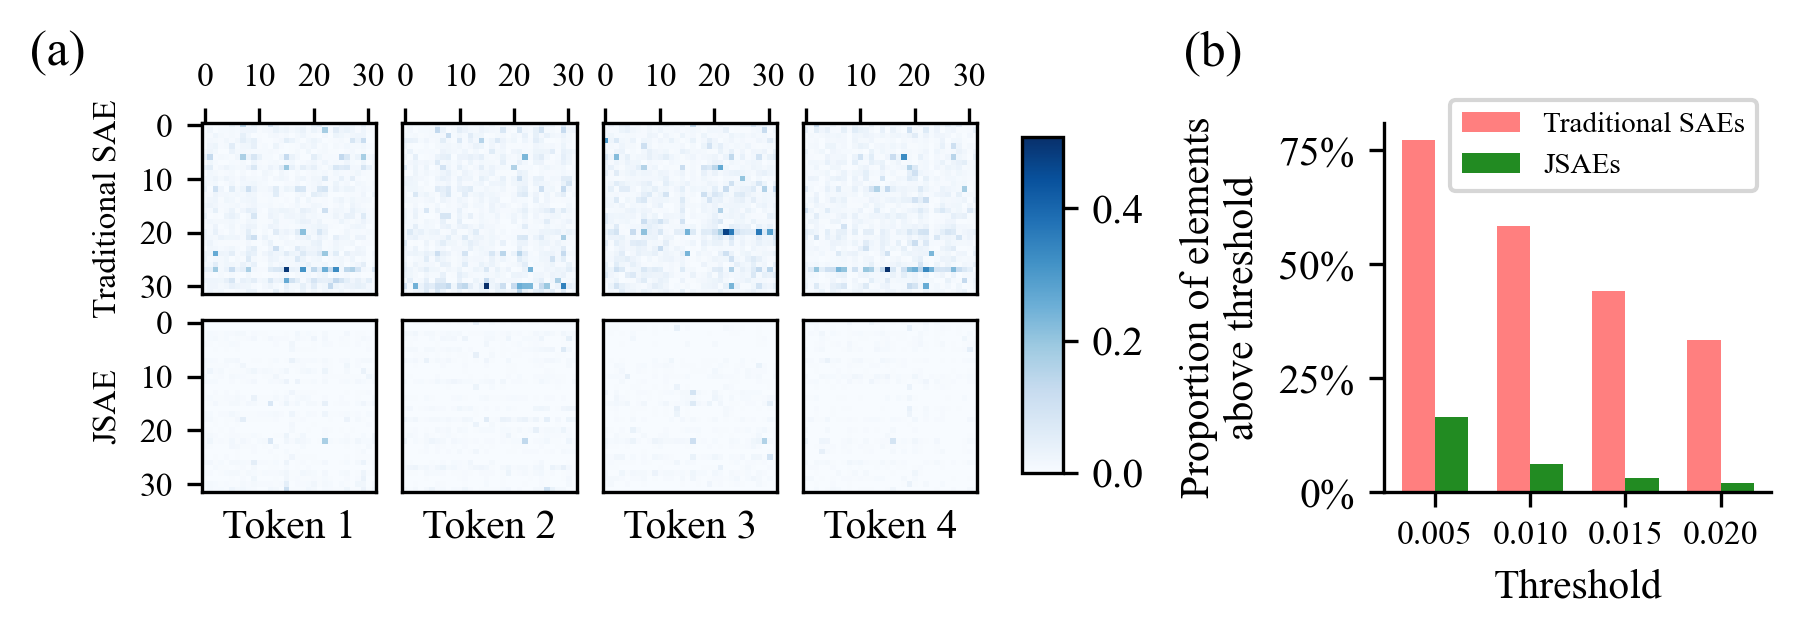

In [26]:
# Figure 1: Example Jacobians + Bar plot
fig1 = plt.figure(figsize=(6.75, 1.6), dpi=300)

gs1 = plt.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.7)

# Left panel: Jacobian examples with no normalization
add_jacobian_panel(fig1, gs1, jacobian, jacobian_no_optim, position='left',
                   normalization=None, width_ratio=2)

# Right panel: Bar plot
ax1 = fig1.add_subplot(gs1[1])
bar_width = 0.35
bar_positions = np.arange(len(thresholds))
ax1.bar(bar_positions, np.array(num_above_thresholds_no_optim) / 1024, bar_width, 
        label='Traditional SAEs', color='red', alpha=0.5)
ax1.bar(bar_positions + bar_width, np.array(num_above_thresholds) / 1024, bar_width, 
        label='JSAEs', color='forestgreen')
ax1.set_xticks(bar_positions + bar_width / 2)
ax1.set_xticklabels([f"{t:.3f}" for t in thresholds], fontsize=8)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Proportion of elements\nabove threshold')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 1.1), fancybox=True, fontsize=7)

plt.figtext(0.04, 1, '(a)', fontsize=12)
plt.figtext(0.61, 1, '(b)', fontsize=12)

plt.savefig('./charts/jac_sparsity_410m.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


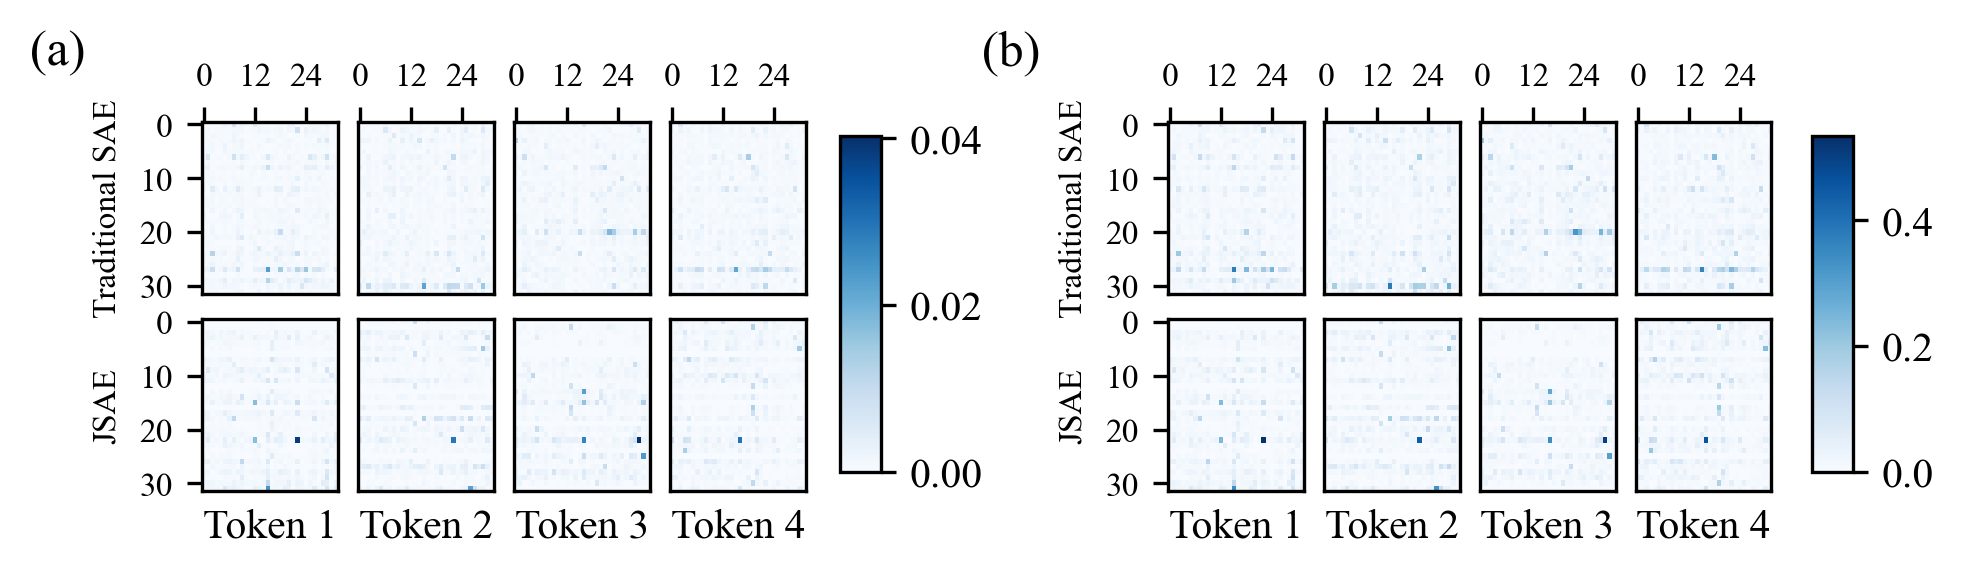

In [27]:
fig2 = plt.figure(figsize=(6.75, 1.6), dpi=300)
gs2 = plt.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.6)

# Left panel: L1 normalized Jacobians
add_jacobian_panel(fig2, gs2, jacobian, jacobian_no_optim, position='left', normalization="L1")

# Right panel: L2 normalized Jacobians
add_jacobian_panel(fig2, gs2, jacobian, jacobian_no_optim, position='right', normalization="L2")

plt.figtext(0.04, 1, '(a)', fontsize=12)
plt.figtext(0.51, 1, '(b)', fontsize=12)

plt.savefig('./charts/jac_examples_normed_410m.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Random LLMs

In [232]:
model = "pythia-70m-deduped"
layer = 3

def get_randomized_hist_path(model: str, layer: int, trained_with_jac: bool, randomized: bool):
    path = f"../results/histograms/sae_pair_{model}"
    if randomized:
        path += "-randomized"
    path += f"_layer{layer}_16384_J{1 if trained_with_jac else 0}_k32:v0.safetensor"
    return path

histograms = {}
with safe_open(get_randomized_hist_path(model, layer, True, False), framework="pt") as f:
    histograms["J1"] = f.get_tensor("hist")
    bin_edges = f.get_tensor("bin_edges")
    n_tokens_in_hist = int(float(f.metadata()["tokens"]))

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
histograms["J1-randomized"] = load_file(get_randomized_hist_path(model, layer, True, True))["hist"]
histograms["J0"] = load_file(get_randomized_hist_path(model, layer, False, False))["hist"]
histograms["J0-randomized"] = load_file(get_randomized_hist_path(model, layer, False, True))["hist"]

thresholds = [0.005, 0.01, 0.015, 0.02]
num_above_thresholds_in_hists = {key: [] for key in histograms.keys()}
for thresh in thresholds:
    # find the index of the bin edge that is equal to the threshold (assume it will always be there)
    idx = torch.where((bin_edges - thresh).abs() < 1e-6)[0].item()
    for key, hist in histograms.items():
        num_above_thresholds_in_hists[key].append(hist[idx:].sum().item() / n_tokens_in_hist)
num_above_thresholds_in_hists = {k: np.array(v) for k, v in num_above_thresholds_in_hists.items()}

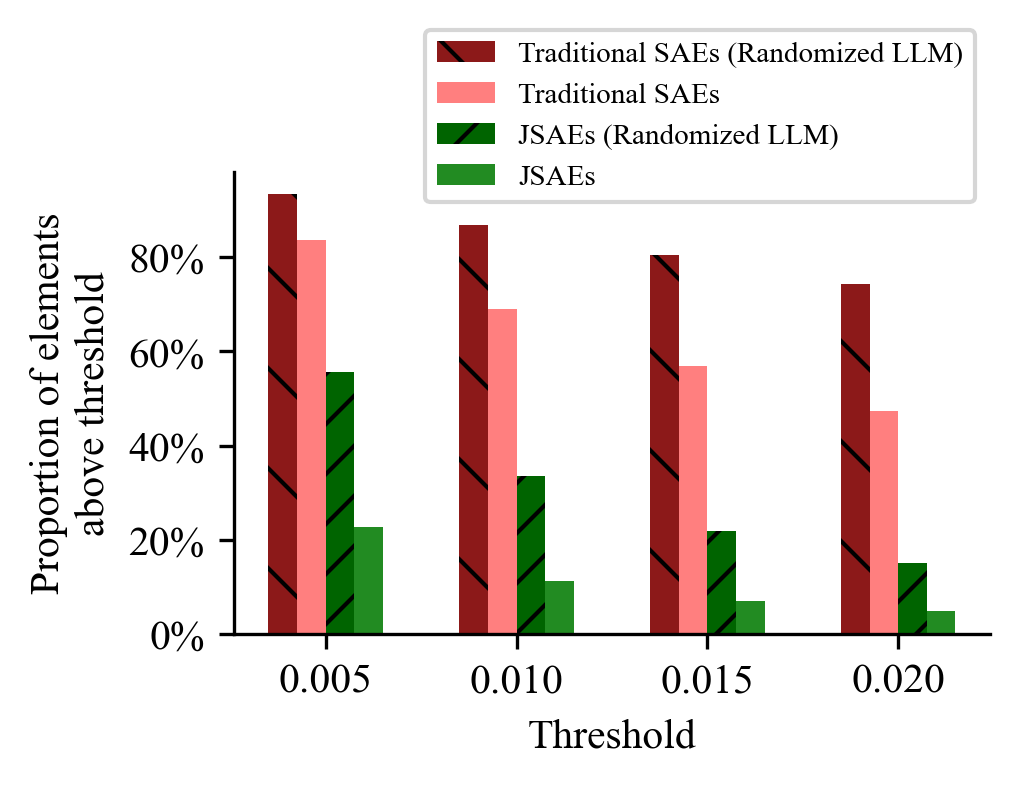

In [233]:
fig = plt.figure(figsize=(3.25, 2), dpi=300)

# Bar plot with 4 bars
bar_width = 0.15
bar_positions = np.arange(len(thresholds))

plt.bar(bar_positions - bar_width, num_above_thresholds_in_hists['J0-randomized'] / 1024, bar_width, 
        label='Traditional SAEs (Randomized LLM)', color='maroon', alpha=0.9, hatch='\\')
plt.bar(bar_positions, num_above_thresholds_in_hists['J0'] / 1024, bar_width, 
        label='Traditional SAEs', color='red', alpha=0.5)
plt.bar(bar_positions + bar_width, num_above_thresholds_in_hists['J1-randomized'] / 1024, bar_width, 
        label='JSAEs (Randomized LLM)', color='darkgreen', hatch='//')
plt.bar(bar_positions + 2*bar_width, num_above_thresholds_in_hists['J1'] / 1024, bar_width, 
        label='JSAEs', color='forestgreen')

# Adjust x-axis to center the labels between all 4 bars
plt.xticks(bar_positions + bar_width/2, [f"{t:.3f}" for t in thresholds])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))
plt.xlabel('Threshold')
plt.ylabel('Proportion of elements\nabove threshold')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.34), fancybox=True, fontsize=7)
plt.savefig('./charts/randomized.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Sweeps

## Jacobian sweep

### CE loss score vs jac elements above 0.01

/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_52013/2464323874.py:5: UserWarning: You're not fetching all of the runs.


  warnings.warn("You're not fetching all of the runs.\n\n")


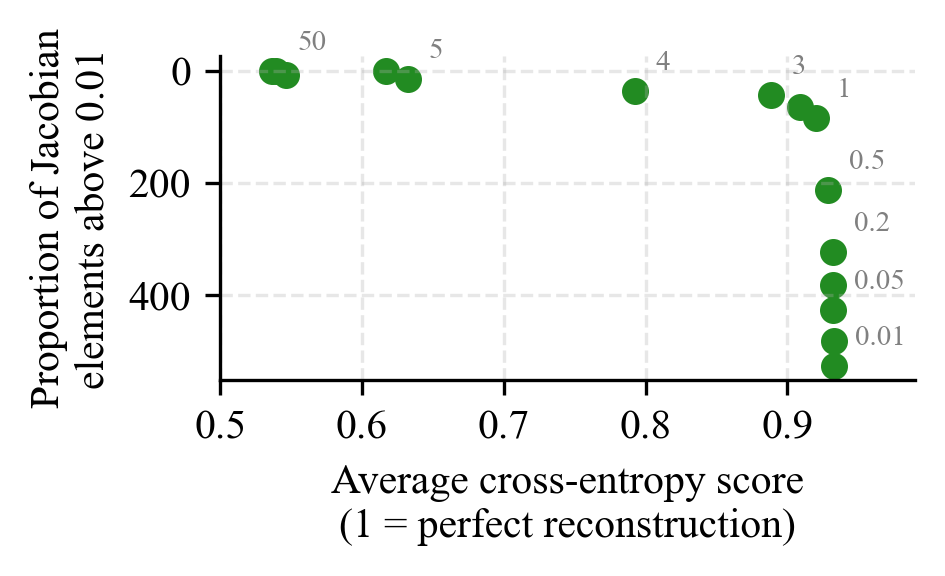

In [42]:
api = wandb.Api()
runs = api.runs("lucyfarnik/pythia70m-l3-sweep-j")

if runs.more:
    warnings.warn("You're not fetching all of the runs.\n\n")

metrics = ["jacobian_sparsity/jac_abs_above_0.01",
           "model_performance_preservation/ce_loss_score",
           "model_performance_preservation/ce_loss_score2"]

data = []
for run in runs:
    if run.state != "finished":
        warnings.warn(f"Run {run.id} is not finished.")
        continue
    run_data = {
        "jacobian_coefficient": run.config["jacobian_coefficient"],
    }
    for m in metrics:
        run_data[m.split("/")[-1]] = run.summary[m]
    data.append(run_data)

df = pd.DataFrame(data)
df["avd_ce_loss_score"] = (df["ce_loss_score"] + df["ce_loss_score2"]) / 2
# df["jac_coeff_with_label"] = df["jacobian_coefficient"].apply(lambda x: f"λ={x}")

plt.figure(figsize=(3.25, 2), dpi=300)

# Create scatter plot
plt.scatter(
    df["avd_ce_loss_score"],
    df["jac_abs_above_0.01"],
    color='forestgreen',
    s=30  # Marker size
)

# Add text annotations for specific values
annotate_values = [0.01, 0.05, 0.2, 0.5, 1, 3, 4, 5, 50]
for _, row in df.iterrows():
    if row["jacobian_coefficient"] in annotate_values:
        jac_coef = row["jacobian_coefficient"]
        if jac_coef == int(jac_coef):
            jac_coef = int(jac_coef)

        plt.annotate(
            f'{jac_coef}',
            (row["avd_ce_loss_score"], row["jac_abs_above_0.01"]),
            xytext=(5, 5),  # Offset
            textcoords='offset points',
            fontsize=7,
            color='gray'
        )

# Customize axes
plt.xlim(0.5, 0.99)
plt.gca().invert_yaxis()  # Reverse y-axis

# Labels
plt.xlabel('Average cross-entropy score\n(1 = perfect reconstruction)', multialignment='center')
plt.ylabel('Proportion of Jacobian\nelements above 0.01', multialignment='center')

# Style adjustments
plt.grid(True, linestyle='--', alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/tradeoff_reconst_jac.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()


TODO rewrite to instead get the data from the eval runner

TODO do a bunch of these for different metrics; the more charts per unit of effort the better

TODO big grid of charts where the charts in a given row always have the same y axis and plots in the same col always have the same x axis
- These should include L1 sparsity dividied by sqrt(L2) — if those don't look as good, we might need to train with that as the objective to demonstrate that we're not just making the Jacs smaller

# $f_s$ is mostly linear


In [12]:
take_abs = True
n_downsampled = 1_000

abl_data = load_file("../results/ablation/sae_pair_pythia-70m-deduped_layer3_16384_J1_k32:v0.safetensor")
abl_samples_full = abl_data["results"]

is_on_line = (abl_samples_full[:, 0] + abl_samples_full[:, 1]).abs() < 0.1

if take_abs:
    abl_samples_full.abs_()
    # abl_samples_no_optim.abs_()


abl_sample_small = abl_samples_full[torch.randint(0, abl_samples_full.shape[0], (n_downsampled,))]


In [19]:
# The numbers in this plot are generated by code in the `fs_approx_linear` notebook
func_examples = load_file("../results/function_examples.safetensor")

In [14]:
def parse_linearity_results(path):
    with open(path) as f:
        results = json.load(f)
        results_sum = sum([v for k, v in results.items() if "count" in k])
        results = {k: v / results_sum for k, v in results.items() if "count" in k}
    return [results["is_linear_count"], results["is_jump_relu_count"], results["is_neither_count"]]

linearity_jsaes = parse_linearity_results("../results/linear/sae_pair_pythia-70m-deduped_layer3_16384_J1_k32:v0.json")
linearity_traditional = parse_linearity_results("../results/linear/sae_pair_pythia-70m-deduped_layer3_16384_J0.0_k32:v0.json")


/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_3685/3252084229.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


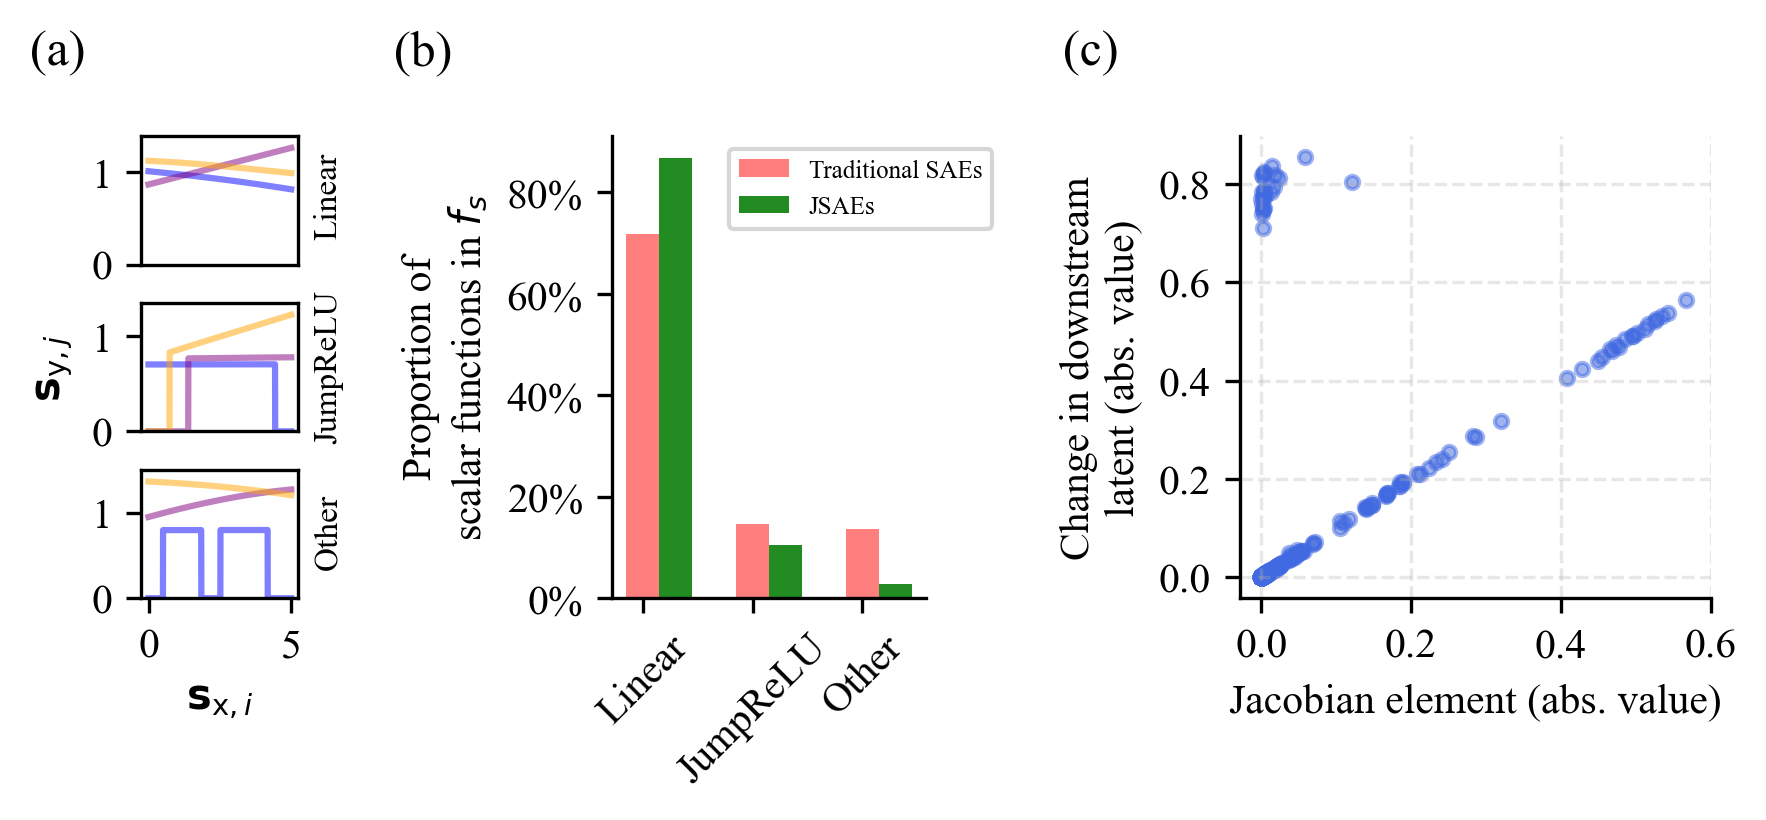

0.9749128818511963

In [33]:
fig = plt.figure(figsize=(6.75, 2), dpi=300)
gs = plt.GridSpec(1, 3, figure=fig, wspace=1, width_ratios=[1, 2, 3])

fig_color = "royalblue"

# Create sub-grid for the first panel
gs_left = gs[0].subgridspec(3, 1, hspace=0.3)

# Create all subplots
ax11 = fig.add_subplot(gs_left[0])  # Top subplot in first panel
ax12 = fig.add_subplot(gs_left[1])  # Middle subplot in first panel
ax13 = fig.add_subplot(gs_left[2])  # Bottom subplot in first panel
ax2 = fig.add_subplot(gs[1])       # Middle panel
ax3 = fig.add_subplot(gs[2])       # Right panel

opacity = 0.5
n_funcs = 3
# colors = ["royalblue" for _ in range(5)]
colors = ['blue', 'purple', 'orange', 'green', 'red']
for idx, ys in enumerate(func_examples["linear_ys"][5-n_funcs:]):
    ax11.plot(func_examples["xs"], ys, color=colors[idx], alpha=opacity)
ax11.set_xticks([])
ax11.set_ylim(0, func_examples["linear_ys"].max() * 1.1)
plt.figtext(0.21, 0.72, 'Linear', rotation=90, fontsize=8)
for idx, ys in enumerate(func_examples["jumprelu_ys"][:n_funcs]):
    ax12.plot(func_examples["xs"], ys, color=colors[idx], alpha=opacity)
ax12.set_xticks([])
ax12.set_ylim(0, func_examples["jumprelu_ys"].max() * 1.1)
ax12.set_ylabel('$\\mathbf{s}_{\\text{y},j}$')
plt.figtext(0.21, 0.38, 'JumpReLU', rotation=90, fontsize=8)
for idx, ys in enumerate(func_examples["other_ys"][:n_funcs]):
    ax13.plot(func_examples["xs"], ys, color=colors[idx], alpha=opacity)
ax13.set_ylim(0, func_examples["other_ys"].max() * 1.1)
ax13.set_xlabel('$\\mathbf{s}_{\\text{x},i}$')
plt.figtext(0.21, 0.17, 'Other', rotation=90, fontsize=8)


bar_width = 0.3
bar_positions = np.arange(3)
ax2.bar(bar_positions, linearity_traditional, bar_width, color="red", label="Traditional SAEs", alpha=0.5)
ax2.bar(bar_positions+bar_width, linearity_jsaes, bar_width, color="forestgreen", label="JSAEs")
ax2.set_xticks(bar_positions, ['Linear', 'JumpReLU', 'Other'], rotation=45)
ax2.set_ylabel('Proportion of\nscalar functions in $f_s$')
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), fancybox=True, fontsize=6)


ax3.scatter(
    abl_sample_small[:, 0].cpu().numpy(),
    abl_sample_small[:, 1].cpu().numpy(),
    color=fig_color,
    alpha=0.5,  # Add some transparency
    s=10,  # Reduce marker size for paper
)
ax3.set_xlabel(f"Jacobian element{' (abs. value)' if take_abs else ''}")
ax3.set_ylabel(f"Change in downstream\nlatent{' (abs. value)' if take_abs else ''}", multialignment='center')
ax3.set_xticks([0, 0.2, 0.4, 0.6])
ax3.grid(True, linestyle='--', alpha=0.3)  # Subtle grid
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)



plt.figtext(0.07, 1, '(a)', fontsize=12)
plt.figtext(0.25, 1, '(b)', fontsize=12)
plt.figtext(0.58, 1, '(c)', fontsize=12)


plt.tight_layout()
plt.savefig('./charts/mostly_linear.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

is_on_line.float().mean().item()

TODO: bar plot for how many examples are on the line vs in the cluster

TODO: chart where each dot is a training run where you change the jac coeff; x axis is reconstruction quality, y axis is sparsity (and also simialr stuff for autointerp et al)

TODO: figure showing that the reconstruction quality (and autointerp) doesn't suffer

# Autointerp

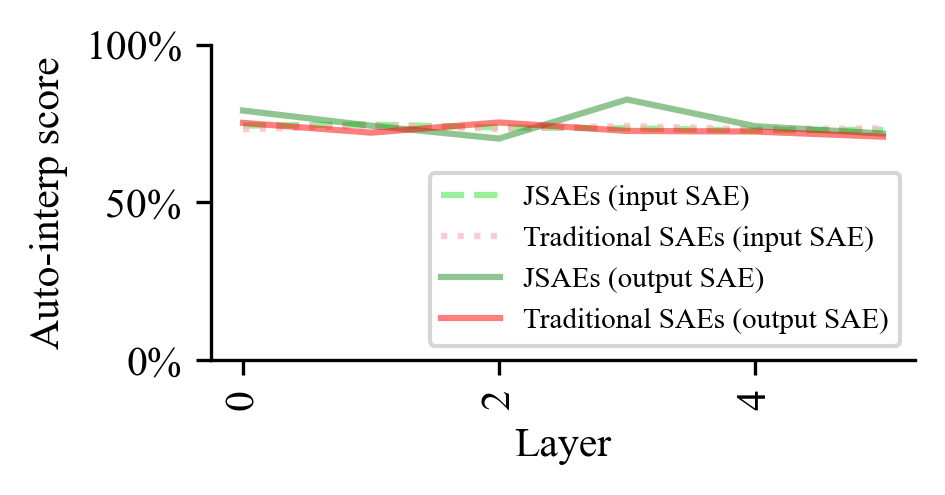

In [196]:
def parse_autointerp_data(path: str):
    with open(path) as f:
        raw_data = json.load(f)
    pre_mlp = []
    post_mlp = []
    for k, v in sorted(raw_data.items()):
        if "mlp" in k:
            post_mlp.append(v["mean"])
        else:
            pre_mlp.append(v["mean"])
    return pre_mlp, post_mlp

jsaes_pre_mlp, jsaes_post_mlp = parse_autointerp_data('../results/autointerp/jsaes/fuzz_results.json')
traditional_pre_mlp, traditional_post_mlp = parse_autointerp_data('../results/autointerp/traditional/fuzz_results.json')

plt.figure(figsize=(3.25, 1.75), dpi=300)

def format_layer(key):
    parts = key.split('.')
    return f"{parts[3]}_{"post-mlp" if parts[4]=="mlp" else "pre-mlp"}"

plt.plot(jsaes_pre_mlp, label='JSAEs (input SAE)', color='lightgreen', alpha=0.9, linestyle='--')
plt.plot(traditional_pre_mlp, label='Traditional SAEs (input SAE)', color='lightpink', alpha=0.7, linestyle=':')
plt.plot(jsaes_post_mlp, label='JSAEs (output SAE)', color='forestgreen', alpha=0.5)
plt.plot(traditional_post_mlp, label='Traditional SAEs (output SAE)', color='red', alpha=0.5)
plt.ylim(0, 1)


plt.legend(loc="lower right", fancybox=True, fontsize=7)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))
plt.xlabel('Layer')
plt.ylabel('Auto-interp score')

# # Style adjustments
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/autointerp_pythia70m.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()